In [1]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import kagglehub
import torch
import os
%matplotlib inline

In [2]:
def download_dataset() -> str:
    path = kagglehub.dataset_download("rishitjakharia/names-txt")
    return path # for easier access later

In [3]:
dataset_path = download_dataset() + "/names.txt"

100%|██████████| 113k/113k [00:00<00:00, 41.7MB/s]

Extracting files...


In [4]:
words = open(dataset_path, 'r').read().splitlines()

In [5]:
def make_int_char_maps() -> tuple[dict, dict]:
  chars = sorted(list(set(''.join(words))))
  ctoi = {c: i + 1 for i, c in enumerate(chars)}
  ctoi['.'] = 0
  itoc = {i: c for c, i in ctoi.items()}
  return ctoi, itoc

In [6]:
ctoi, itoc = make_int_char_maps()

In [7]:
print(itoc)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [8]:
print(ctoi)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


In [9]:
vocab_size = len(ctoi)
print(vocab_size)

27


In [10]:
def build_dataset(inp_words) -> tuple[torch.tensor, torch.tensor]:

  block_size = 3 # context length -> how many chars does it take to predict the next
  inp, target = [], []
  for w in inp_words:
    context = [0] * block_size

    for ch in w + '.':
      ix = ctoi[ch]
      inp.append(context)
      target.append(ix)
      context = context[1:] + [ix] # crop and append

  inp = torch.tensor(inp)
  target = torch.tensor(target)
  return inp, target

In [11]:
import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

In [12]:
Xtr.shape, Xval.shape, Xtest.shape

(torch.Size([182625, 3]), torch.Size([22655, 3]), torch.Size([22866, 3]))

In [ ]:
inp, target = build_dataset(words)

In [ ]:
inp.shape, target.shape, inp.dtype, target.dtype

(torch.Size([228146, 3]), torch.Size([228146]), torch.int64, torch.int64)

In [ ]:
C = torch.randn(27, 2) # 27 characters mapping to a 2d vector embedding`

In [ ]:
C[5]

tensor([0.1419, 0.4920])

In [ ]:
(F.one_hot(torch.tensor(5), num_classes=27).float() @ C) # one hot allows us to pluck out a desired row
                                                         # however, notice its the same as indexing, so this wont be used

tensor([0.1419, 0.4920])

inp contains contexts, defined in build dataset above
each context contains index mappings from ctoi.
these allow us to access embeddings in C.
we can index into C efficienty with the help of PyTorch

In [ ]:
C[inp].shape

torch.Size([228146, 3, 2])

In [13]:
n_emb = 10 # number of dimensions in emb
n_hidden = 200 # number of neurons in hidden layer
block_size = 3 # size of each context
C = torch.randn((vocab_size, n_emb)) # embedding

In [ ]:
emb = C[Xtr]
W1 = torch.randn((n_emb * block_size, n_hidden)) # this is our hiddem layer, recieving 6 inputs, since each input has three characters, each having two elements
B1 = torch.randn(n_hidden) # 100 biases for each weight

In [ ]:
h = torch.tanh(emb.view(-1, block_size * n_emb) @ W1 + B1)

In [ ]:
h

tensor([[ 0.9994, -0.9986,  0.9970,  ..., -1.0000, -0.9475, -1.0000],
        [-0.3401,  0.9835, -0.9999,  ..., -1.0000, -0.9900, -1.0000],
        [-0.4049, -1.0000,  0.9997,  ..., -1.0000,  0.9999,  0.9516],
        ...,
        [-0.9899,  0.9771,  1.0000,  ...,  0.9371, -1.0000, -1.0000],
        [ 0.9999,  1.0000,  0.9963,  ..., -0.9997, -1.0000, -0.7203],
        [ 0.9967, -0.9982,  0.9834,  ..., -0.9998, -0.9070, -1.0000]])

In [ ]:
W2 = torch.randn(n_hidden, vocab_size)
B2 = torch.randn(vocab_size)

In [ ]:
logits = h @ W2 + B2

In [ ]:
counts = logits.exp()

In [ ]:
probs = counts / counts.sum(1, keepdim=True)

In [ ]:
probs[torch.arange(Xtr.shape[0]), Ytr] # the probabilties for our target characters for each input

tensor([1.6303e-13, 2.3997e-03, 1.5272e-05,  ..., 1.1138e-14, 3.0071e-12,
        7.6601e-15])

In [ ]:
loss = -probs[torch.arange(Xtr.shape[0]), Ytr].log().mean()

In [ ]:
loss.item()

24.592586517333984

Now altogether

In [ ]:
W1 = torch.randn((n_emb * block_size, n_hidden))
B1 = torch.randn(n_hidden)
W2 = torch.randn(n_hidden, vocab_size)
B2 = torch.randn(vocab_size)
params = [C, W1, B1, W2, B2]

In [ ]:
sum(p.nelement() for p in params ) # number of parameters

11897

In [ ]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, block_size * n_emb) @ W1 + B1)
logits = h @ W2 + B2
counts = logits.exp()
probs = counts / counts.sum(1, keepdim=True)
loss = -probs[torch.arange(Xtr.shape[0]), Ytr].log().mean()

In [ ]:
loss # this loss is different from above because we initialize new random weights and biases

tensor(25.7667)

F.cross_entropy on logits and target does this calculation, giving the same loss when we calculate counts to -prob[torch.arange(32), target].log().mean() is calculated, but much quicker

In [ ]:
logit = torch.tensor([-5, 0, 3, 5]) + 6
count = logit.exp()
prob = count / count.sum()
prob

tensor([3.9751e-05, 5.8995e-03, 1.1849e-01, 8.7557e-01])

Any constant we add to logits will still result in the same prob ...
Let the logits be:
$$
\text{logit} = \begin{bmatrix} -5 \\ 0 \\ 3 \\ 5 \end{bmatrix} + 6 = \begin{bmatrix} 1 \\ 6 \\ 9 \\ 11 \end{bmatrix}
$$

Exponentiated values:
$$
\text{count} = \exp(\text{logit}) = \begin{bmatrix} e^1 \\ e^6 \\ e^9 \\ e^{11} \end{bmatrix}
$$

This Also Equals
$$
\exp(\text{logit}) = e^6 ⋅ \begin{bmatrix} e^{-5} \\ e^0 \\ e^3 \\ e^{5} \end{bmatrix}
$$

Normalized probabilities:
$$
\text{prob} = \frac{\text{count}}{\sum \text{count}} = \frac{e^6 \cdot \begin{bmatrix} e^{-5} \\ e^0 \\ e^3 \\ e^5 \end{bmatrix}}{e^6 \cdot (e^{-5} + e^0 + e^3 + e^5)}
$$

Further:
$$
\text{prob} = \frac{\text{count}}{\sum \text{count}} = \frac{\begin{bmatrix} e^{-5} \\ e^0 \\ e^3 \\ e^5 \end{bmatrix}}{e^{-5} + e^0 + e^3 + e^5} \text{, Which is simply the normalization of our original tensor}
$$

Adding a constant to our logits does not change the probability tensor, given we don't go out of bounds when calculating exp. Negative numbers will be useful here, since if we have a overflowing number already in our logits, then it can overflow in counts, but if we offset by -max(logits) then we can can ensure no overflow, previously I was doing this calculation manually, but this is actually handled by F.cross_entropy

In [ ]:
# overflow example
logit = torch.tensor([-5, 0, 3, 100])
count = logit.exp()
prob = count / count.sum()
prob

tensor([0., 0., 0., nan])

In [ ]:
# fixing overflow
logit = torch.tensor([-5, 0, 3, 100]) - logit.max()
count = logit.exp()
prob = count / count.sum()
prob

tensor([0.0000e+00, 3.7835e-44, 7.4689e-43, 1.0000e+00])

In [ ]:
# further showing we can add any constant as long as we dont overflow
logit = torch.tensor([-5, 0, 3, 100]) - logit.max() + 1
count = logit.exp()
prob = count / count.sum()
prob

tensor([0., 0., 0., nan])

Continuing

In [ ]:
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [14]:
kaiming_init = (5/3) / ((n_emb * block_size) ** 0.5)

In [15]:
C = torch.randn(vocab_size, n_emb)
W1 = torch.randn((n_emb * block_size, n_hidden)) * kaiming_init # fixing saturated tanh, since it couldve been creating dead neurons at init
#B1 = torch.randn(n_hidden) * 0.01 # same ideology here
W2 = torch.randn(n_hidden, vocab_size) * 0.01 # scaling down to get logits close to 0 at init
B2 = torch.randn(vocab_size) * 0 # we dont want to add random numbers in logits at initilization

Bngain = torch.ones(1, n_hidden) # we want gaussian for hidden layer at normlization but not during the entire training
Bnbias = torch.zeros(1, n_hidden)
Bnmean_running = torch.zeros(1, n_hidden)
Bnstd_running = torch.ones(1, n_hidden)

params = [C, W1, W2, B2]
for p in params:
  p.requires_grad = True

In [16]:
batch_size = 32
max_steps = 200_000
lossi = []

In [ ]:
for i in range(max_steps):

  # mini batches
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb]
  embcat = emb.view(-1, block_size * n_emb)
  preh = embcat @ W1
  bnmeani = preh.mean(0, keepdim=True)
  bnstdi = preh.std(0, keepdim=True)
  preh_norm = Bngain * ((preh - bnmeani) / bnstdi) + Bnbias

  with torch.no_grad():
    Bnmean_running = 0.999 * Bnmean_running + 0.001 * bnmeani
    Bnstd_running = 0.999 * Bnstd_running + 0.001 * bnstdi

  h = torch.tanh(preh_norm)
  logits = h @ W2 + B2
  loss = F.cross_entropy(logits, Ytr[ix])

  # reset grads
  for p in params:
    p.grad = None

  # backward pass
  loss.backward()

  lr = 0.1
  if i > 100_000:
    lr = 0.01

  for p in params:
    p.data += p.grad * -lr

  lossi.append(loss.log10().item())

  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

  #break
print("200000/200000: ", loss.item())

      0/ 200000: 3.2829
  10000/ 200000: 2.2780
  20000/ 200000: 2.3616
  30000/ 200000: 2.8378
  40000/ 200000: 2.3681
  50000/ 200000: 2.0520
  60000/ 200000: 2.1223
  70000/ 200000: 2.0801
  80000/ 200000: 2.1346
  90000/ 200000: 1.9683
 100000/ 200000: 1.9358
 110000/ 200000: 2.1990
 120000/ 200000: 2.2910
 130000/ 200000: 1.9767
 140000/ 200000: 2.0112
 150000/ 200000: 2.1324
 160000/ 200000: 2.0135
 170000/ 200000: 2.0179
 180000/ 200000: 2.2759
 190000/ 200000: 1.9735
200000/200000:  2.2948787212371826


In [ ]:
B1.grad

tensor([ 6.9849e-10, -1.8626e-09, -1.2224e-09,  1.8626e-09, -1.6298e-09,
         2.7940e-09,  1.3970e-09,  3.7253e-09,  0.0000e+00, -1.1642e-09,
         4.6566e-10, -6.9849e-10,  2.3283e-10,  0.0000e+00, -4.6566e-10,
         6.9849e-10,  0.0000e+00,  1.3970e-09,  9.3132e-10, -1.3970e-09,
        -4.6566e-10, -4.6566e-10,  0.0000e+00, -4.6566e-10,  0.0000e+00,
         0.0000e+00, -9.3132e-10, -1.1642e-09,  3.7835e-10,  9.3132e-10,
         4.6566e-10, -2.3283e-10,  0.0000e+00,  9.3132e-10,  4.6566e-10,
         1.3970e-09,  9.3132e-10, -4.6566e-10,  1.8626e-09, -1.8626e-09,
        -6.9849e-10, -9.3132e-10,  0.0000e+00,  1.8626e-09, -4.6566e-10,
         2.3283e-10, -9.3132e-10,  8.7311e-10,  2.3283e-10, -2.7940e-09,
        -1.8626e-09, -2.9104e-09,  0.0000e+00,  1.3970e-09, -1.2806e-09,
         2.3283e-10,  0.0000e+00, -4.6566e-10,  1.8626e-09,  0.0000e+00,
        -1.8626e-09, -9.3132e-10, -8.1491e-10, -9.3132e-10, -6.9849e-10,
         0.0000e+00,  0.0000e+00,  1.3970e-09,  0.0

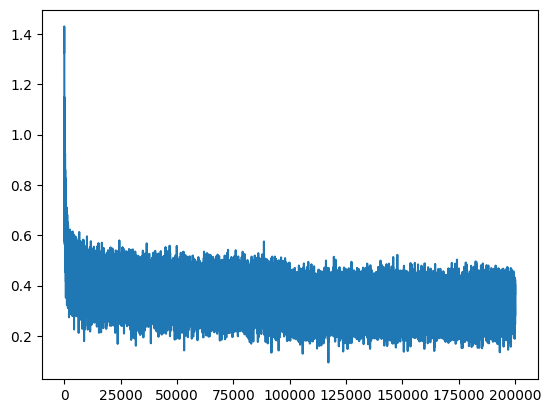

In [ ]:
plt.plot(lossi) # before optimization

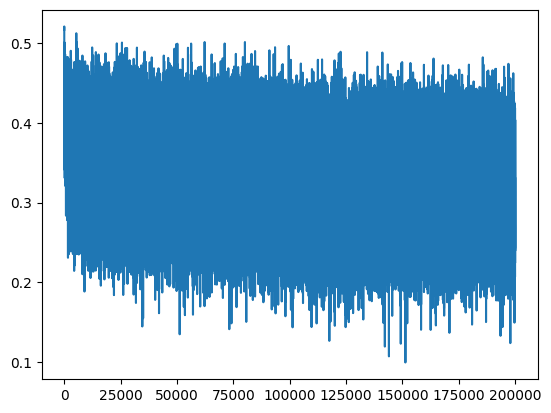

In [ ]:
# after
plt.plot(lossi) # no hockey stick

In [ ]:
@torch.no_grad() #decorator to disable grad tracking during eval in the function context
def split_loss(split) -> float:
  x, y = {
    'train': (Xtr, Ytr),
    'val': (Xval, Yval),
    'test': (Xtest, Ytest),
  }[split]

  emb = C[x]
  embcat = emb.view(-1, block_size * n_emb)
  preh = embcat @ W1 + B1
  preh_norm = Bngain * ((preh - Bnmean_running) / Bnstd_running) + Bnbias
  h = torch.tanh(preh_norm)
  logits = h @ W2 + B2
  loss = F
  return F.cross_entropy(logits, y).item()

In [ ]:
print(split_loss('train'))
print(split_loss('val'))

2.082388162612915
2.116393804550171


In [74]:
# pytorch-ifying

class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    # kaiming init for linear layers
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True


47024


In [75]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function

  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2870


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.78%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.56%
layer 8 (      Tanh): mean -0.00, std 0.65, saturated: 2.25%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.69%
layer 14 (      Tanh): mean +0.00, std 0.65, saturated: 1.88%


Text(0.5, 1.0, 'activation distribution')

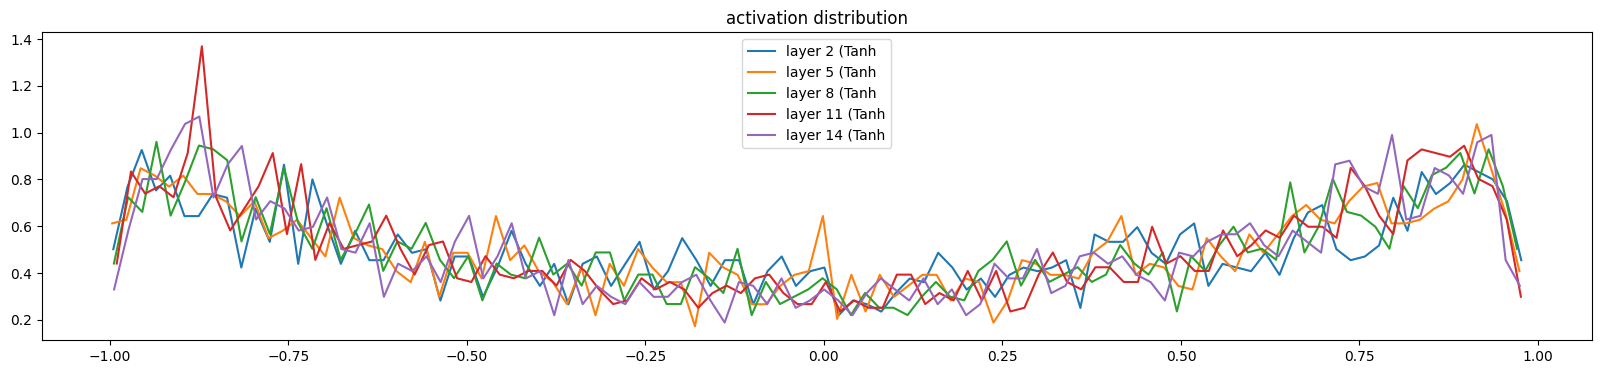

In [76]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 2.640702e-03
layer 5 (      Tanh): mean -0.000000, std 2.245584e-03
layer 8 (      Tanh): mean +0.000000, std 2.045741e-03
layer 11 (      Tanh): mean +0.000000, std 1.983133e-03
layer 14 (      Tanh): mean -0.000000, std 1.952381e-03


Text(0.5, 1.0, 'gradient distribution')

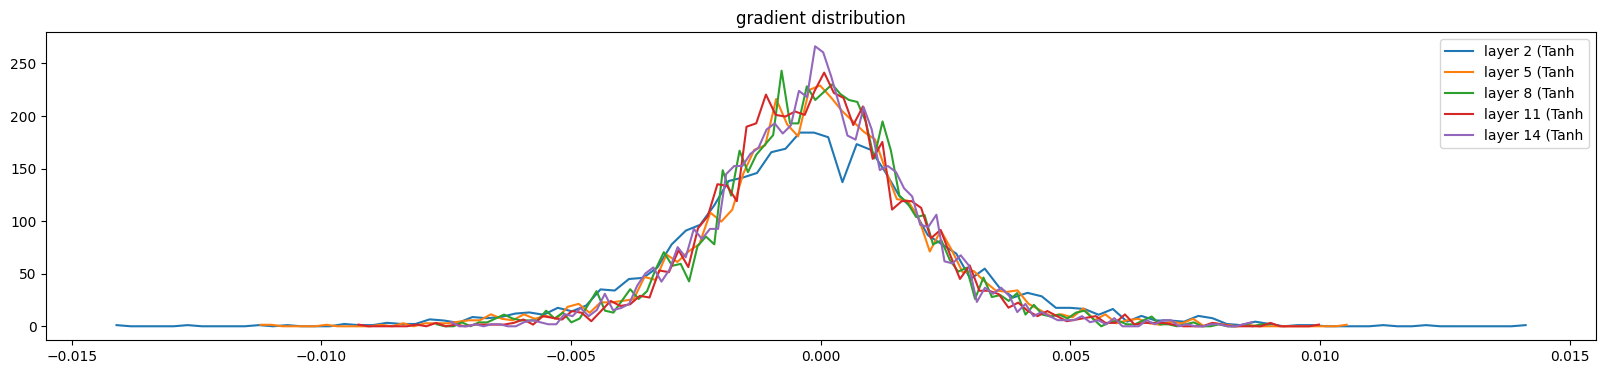

In [77]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 8.020530e-03 | grad:data ratio 8.012626e-03
weight  (30, 100) | mean +0.000246 | std 9.241073e-03 | grad:data ratio 4.881089e-02
weight (100, 100) | mean +0.000113 | std 7.132873e-03 | grad:data ratio 6.964613e-02
weight (100, 100) | mean -0.000086 | std 6.234301e-03 | grad:data ratio 6.073737e-02
weight (100, 100) | mean +0.000052 | std 5.742181e-03 | grad:data ratio 5.631477e-02
weight (100, 100) | mean +0.000032 | std 5.672203e-03 | grad:data ratio 5.570123e-02
weight  (100, 27) | mean -0.000082 | std 1.209415e-02 | grad:data ratio 1.160105e-01


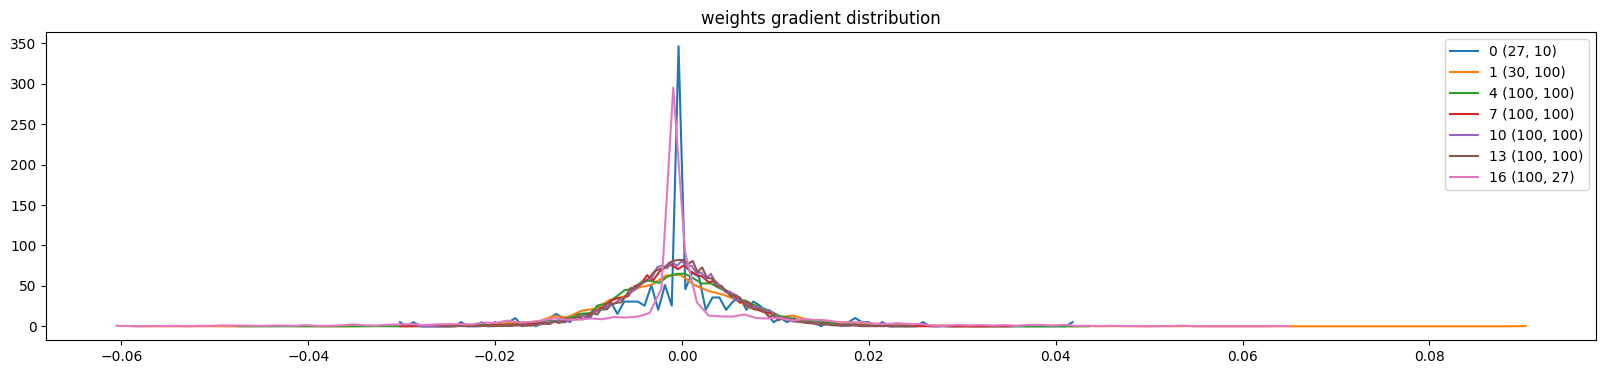

In [78]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

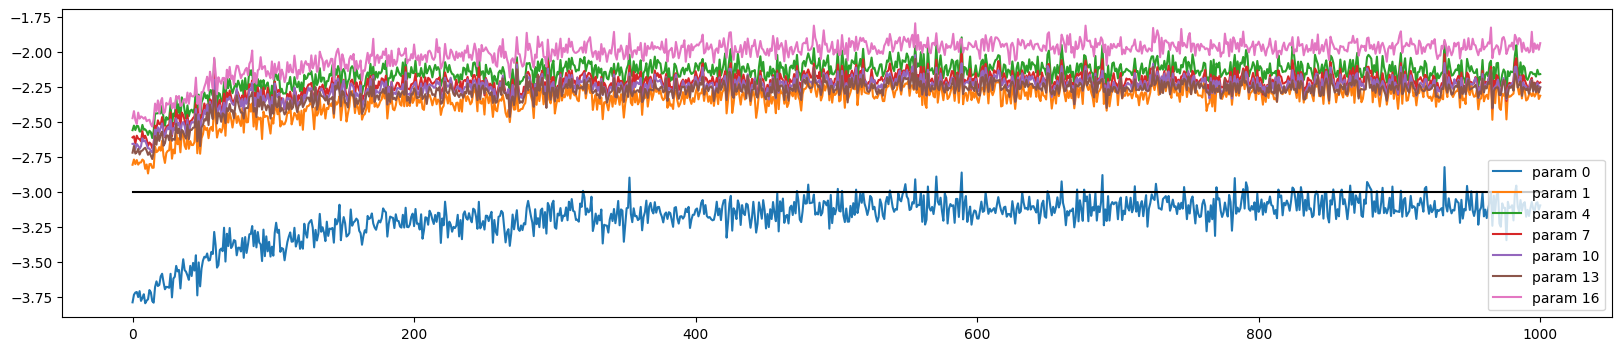

In [79]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [ ]:
# sampling from model

for _ in range(20):

  out = []
  context = [0] * block_size

  while True:
    emb = C[torch.tensor([context])]

    h = torch.tanh(emb.view(1, -1) @ W1 + B1)
    logits = h @ W2 + B2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break

  print(''.join(itoc[i] for i in out))